# Dynamic Pricing for Urban Parking Lots

In [ ]:
!pip install pathway bokeh --quiet # This cell may take a few seconds to execute.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn

In [ ]:
url = "https://drive.google.com/uc?id=1D479FLjp9aO3Mg8g6Lpj9oRViWacurA6"


df = pd.read_csv(url)
df

# You can find the sample dataset here: https://drive.google.com/file/d/1D479FLjp9aO3Mg8g6Lpj9oRViWacurA6/view?usp=sharing

,Unnamed: 0,SystemCodeNumber,Capacity,Occupancy,LastUpdatedDate,LastUpdatedTime,IsSpecialDay,VehicleType,Latitude,Longitude,TrafficConditionNearby,QueueLength
0,0,BHMBCCMKT01,577,61,04-10-2016,07:59:42,0,car,28.5,77.15,low,2
1,1,BHMBCCMKT01,577,64,04-10-2016,08:25:42,0,car,28.5,77.15,average,2
2,2,BHMBCCMKT01,577,80,04-10-2016,08:59:42,0,car,28.5,77.15,low,2
3,3,BHMBCCMKT01,577,107,04-10-2016,09:32:46,0,car,28.5,77.15,low,3
4,4,BHMBCCMKT01,577,150,04-10-2016,09:59:48,0,car,28.5,77.15,low,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1307,1307,BHMBCCMKT01,577,309,19-12-2016,14:30:33,0,bike,28.5,77.15,average,5
1308,1308,BHMBCCMKT01,577,300,19-12-2016,15:03:34,0,car,28.5,77.15,low,4
1309,1309,BHMBCCMKT01,577,274,19-12-2016,15:29:33,0,truck,28.5,77.15,low,3
1310,1310,BHMBCCMKT01,577,230,19-12-2016,16:03:35,0,cycle,28.5,77.15,low,2


# Preprocessing the Data

In [ ]:
# Combine the 'LastUpdatedDate' and 'LastUpdatedTime' columns into a single datetime column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

# Sort the DataFrame by the new 'Timestamp' column and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)

In [ ]:
# Save the selected columns to a CSV file for streaming or downstream processing
df[["Timestamp", "Occupancy", "Capacity"]].to_csv("parking_stream.csv", index=False)

# Note: Only three features are used here for simplicity.
# Participants are expected to incorporate additional relevant features in their models.

In [ ]:
# Define the schema for the streaming data using Pathway
# This schema specifies the expected structure of each data row in the stream

class ParkingSchema(pw.Schema):
    Timestamp: str   # Timestamp of the observation (should ideally be in ISO format)
    Occupancy: int   # Number of occupied parking spots
    Capacity: int    # Total parking capacity at the location


In [ ]:
# Load the data as a simulated stream using Pathway's replay_csv function
# This replays the CSV data at a controlled input rate to mimic real-time streaming
# input_rate=1000 means approximately 1000 rows per second will be ingested into the stream.

data = pw.demo.replay_csv("parking_stream.csv", schema=ParkingSchema, input_rate=1000)

In [ ]:
# Define the datetime format to parse the 'Timestamp' column
fmt = "%Y-%m-%d %H:%M:%S"

# Add new columns to the data stream:
# - 't' contains the parsed full datetime
# - 'day' extracts the date part and resets the time to midnight (useful for day-level aggregations)
data_with_time = data.with_columns(
    t = data.Timestamp.dt.strptime(fmt),
    day = data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00")
)


# Model 1 - Baseline Linear Model

In [ ]:
# STEP 2: Your Capstone Code Starts Here
import pathway as pw
from pathway.io.csv import read, write

# Define your schema (modern version uses Python types)
class ParkingSchema(pw.Schema):
    Timestamp: str
    Occupancy: int
    Capacity: int

# STEP 4: Load the CSV as a stream (replace with your real file if needed)
source = read(
    "parking_stream.csv",  # your CSV file
    schema=ParkingSchema,
    mode="streaming",       # treat as real-time stream
    autocommit_duration_ms=1000,
)

# STEP 5: Model 1 Pricing Logic (baseline)
@pw.udf
def model1_price(occupancy, capacity):
    base_price = 10
    alpha = 0.2
    price = base_price + alpha * (occupancy / capacity)
    return round(min(max(price, 5), 20), 2)  # clamp price between $5 and $20

# STEP 6: Apply pricing
result = source.select(
    Timestamp = source.Timestamp,
    Occupancy = source.Occupancy,
    Capacity = source.Capacity,
    Price = model1_price(source.Occupancy, source.Capacity)
)

# STEP 7: Write to output CSV
write(result, "final_prices.csv")

# STEP 8: Execute
pw.run()


Output()

/usr/local/lib/python3.11/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


KeyboardInterrupt: 

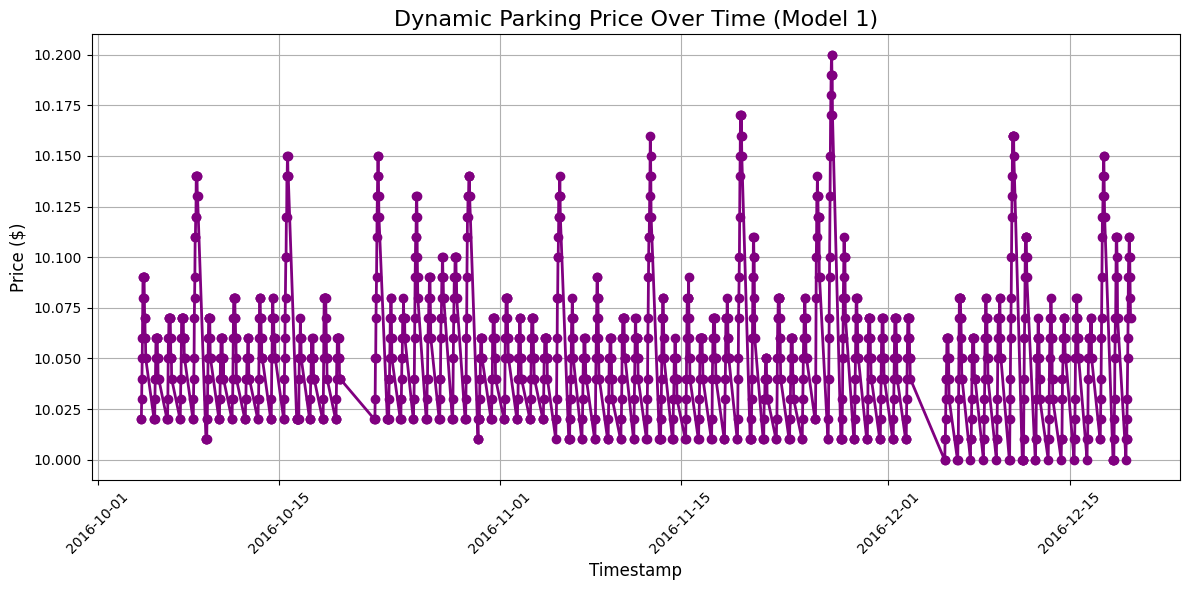

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV that was generated earlier
df = pd.read_csv("final_prices.csv")

# Convert Timestamp to datetime (if not already)
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Sort by Timestamp for plotting
df = df.sort_values("Timestamp")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df["Timestamp"], df["Price"], marker="o", color="purple", linewidth=2)
plt.title("Dynamic Parking Price Over Time (Model 1)", fontsize=16)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Model 2 - Demand-Based Price Function

In [ ]:
import pandas as pd
import random

df = pd.read_csv("parking_stream.csv")

# Fill with sample data
df["QueueLength"] = [random.randint(0, 5) for _ in range(len(df))]
df["Traffic"] = [round(random.uniform(0.2, 1.0), 2) for _ in range(len(df))]
df["IsSpecialDay"] = [random.choice([0, 1]) for _ in range(len(df))]
df["VehicleType"] = [random.choice(["car", "bike", "truck"]) for _ in range(len(df))]

# Overwrite CSV
df.to_csv("parking_stream.csv", index=False)


In [ ]:
# ✅ Step 1: Clean Model 2 Implementation
import pathway as pw
from pathway.io.csv import read, write

# Define schema for extended CSV
class ParkingSchema(pw.Schema):
    Timestamp: str
    Occupancy: int
    Capacity: int
    QueueLength: int
    Traffic: float
    IsSpecialDay: int
    VehicleType: str

# Stream data from the prepared CSV
source = read(
    "parking_stream.csv",
    schema=ParkingSchema,
    mode="streaming",
    autocommit_duration_ms=1000,
)

# Vehicle type weights
vehicle_weights = {
    "car": 1.0,
    "bike": 0.5,
    "truck": 1.5
}

# Model 2 Pricing Logic
@pw.udf
def model2_price(occupancy, capacity, queue, traffic, special, vehicle):
    alpha, beta, gamma, delta, epsilon = 0.4, 0.3, 0.2, 0.2, 0.5
    base_price = 10.0

    if capacity == 0:
        return base_price

    vt_weight = vehicle_weights.get(vehicle.lower(), 1.0)

    demand = (
        alpha * (occupancy / capacity) +
        beta * queue -
        gamma * traffic +
        delta * special +
        epsilon * vt_weight
    )

    price = base_price * (1 + 0.1 * demand)
    return round(min(max(price, 5), 20), 2)  # Clamp between $5 and $20

# Generate result table
result = source.select(
    Timestamp=source.Timestamp,
    Occupancy=source.Occupancy,
    Capacity=source.Capacity,
    Price=model2_price(
        source.Occupancy,
        source.Capacity,
        source.QueueLength,
        source.Traffic,
        source.IsSpecialDay,
        source.VehicleType,
    )
)

# Export to CSV
write(result, "final_prices.csv")

# Execute pipeline
pw.run()


Output()

KeyboardInterrupt: 

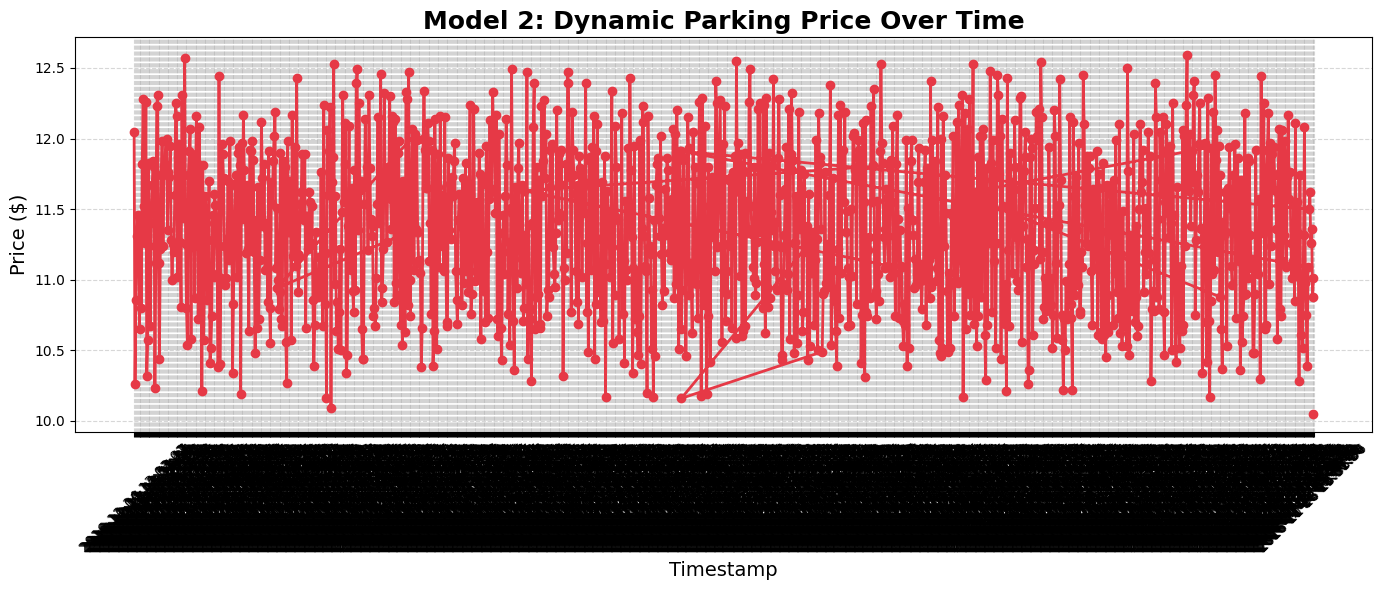

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df["Timestamp"], df["Price"], color="#E63946", marker="o", linewidth=2)

plt.title("Model 2: Dynamic Parking Price Over Time", fontsize=18, fontweight='bold')
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Price ($)", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
